In [1]:
import torch
import pickle
import numpy as np
from evaluation import *
from functions import *
from Models.UNet import *
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Loading dataset
x = pickle.load(open("./Xs.pkl", "rb"))
y = pickle.load(open("./Ys.pkl", "rb"))

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)

In [4]:
# Shifting dimensions
x, y = x.permute(0, 3, 1, 2), y.permute(0, 3, 1, 2)
# Removing channel 1 in input channels
x = torch.cat((x[:, 0:1, :, :], x[:, 2:, :, :]), dim=1)
# Adding binary channel to describe the shape of object
bin_channel = torch.isnan(x[:, 2:, :, :]).type(torch.float)
x = torch.cat([x, bin_channel], dim=1)
print(torch.sum(bin_channel))

tensor(467592.)
torch.Size([961, 4, 172, 79]) torch.Size([961, 1, 172, 79])


In [5]:
# Removing NaN values
x[torch.isnan(x)] = 0
y[torch.isnan(y)] = 0

In [6]:
# Computing Root Mean Square of features to equally prioritize each feature in loss function
features_mse = torch.sqrt(torch.mean(y.permute(0, 2, 3, 1).view(-1, y.shape[1]) ** 2, dim=0)).view(1, -1, 1, 1).to(device)
print(features_mse)

tensor([[[[0.0135]]]], device='cuda:0')


In [7]:
print(x.shape)
print(y.shape)

torch.Size([961, 4, 172, 79])
torch.Size([961, 1, 172, 79])


In [8]:
# Shuffling the dataset
x, y = shuffle_tensors(x, y)

In [9]:
# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x, y, ratio=0.7)
train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)

In [10]:
# Creating model
model = UNet(4, 1, filters=[8,16,32,32], kernel_size=5,
                    batch_norm=False, weight_norm=False)
model

UNet(
  (encoder): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
      )
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
      )
    )
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
      )
    )
    (3): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), paddin

In [11]:
# Initializing weights
# initialize(model)

In [12]:
# Initializing optimizer
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [19]:
# Defining loss function
def loss_func(model, batch):
    x, y = batch
    output = model(x)
    loss = torch.abs((output - y)) / features_mse
    return torch.sum(loss), output

In [20]:
# Selecting sample from test dataset for visualization
sample_x, sample_y = test_data[0][0:1].to(device), test_data[1][0:1].to(device)

In [21]:
# Computing output and error for test sample
def compute_error(model, sample_x, sample_y):
    with torch.no_grad():
        out_y = model(sample_x)
        error = torch.abs(sample_y - out_y)
        return out_y, error

In [22]:
# Visualize sample
def visualize(sample_y, out_y, error):
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(15, 10)

    plt.subplot(3, 3, 7)
    plt.imshow(np.transpose(sample_y[0,0,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('p', fontsize=18)
    plt.subplot(3, 3, 8)
    plt.imshow(np.transpose(out_y[0,0,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 9)
    plt.imshow(np.transpose(error[0,0,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.tight_layout()
    plt.show()

In [23]:
# Visualize after N epochs
def after_epoch(scope):
    epoch = scope["epoch"]
    best_model = scope["best_model"]
    if epoch % 10 == 0:
        out_y, error = compute_error(best_model, sample_x, sample_y)
        visualize(sample_y.cpu().numpy(), out_y.cpu().numpy(), error.cpu().numpy())

Epoch #1
	Train Loss = 2729110.65625
	Train Total MSE = 1.2343003615027381
	Train p MSE = 1.2343003615027381
	Validation Loss = 814500.2741699219
	Validation Total MSE = 1.2026308800728676
	Validation p MSE = 1.2026308800728676
Model saved!
Epoch #2
	Train Loss = 1578292.9453125
	Train Total MSE = 1.0553478577307291
	Train p MSE = 1.0553478577307291
	Validation Loss = 665324.0836181641
	Validation Total MSE = 1.137371258649034
	Validation p MSE = 1.137371258649034
Model saved!
Epoch #3
	Train Loss = 1386335.2109375
	Train Total MSE = 1.0264731383039838
	Train p MSE = 1.0264731383039838
	Validation Loss = 632324.4777832031
	Validation Total MSE = 1.1434514833723797
	Validation p MSE = 1.1434514833723797
Model saved!
Epoch #4
	Train Loss = 1369505.27734375
	Train Total MSE = 1.0169994941069966
	Train p MSE = 1.0169994941069966
	Validation Loss = 636364.3690185547
	Validation Total MSE = 1.129974093507318
	Validation p MSE = 1.129974093507318
Epoch #5
	Train Loss = 1339453.71484375
	Train

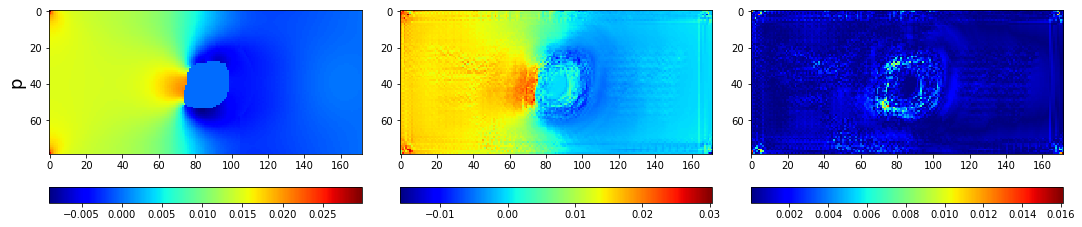

Epoch #11
	Train Loss = 1245976.0703125
	Train Total MSE = 1.0145140217528457
	Train p MSE = 1.0145140217528457
	Validation Loss = 553885.5876464844
	Validation Total MSE = 1.1185450658949807
	Validation p MSE = 1.1185450658949807
Model saved!
Epoch #12
	Train Loss = 1216686.70703125
	Train Total MSE = 1.0073183242763792
	Train p MSE = 1.0073183242763792
	Validation Loss = 577978.1774902344
	Validation Total MSE = 1.124086853683923
	Validation p MSE = 1.124086853683923
Epoch #13
	Train Loss = 1204999.81640625
	Train Total MSE = 1.0053339327375095
	Train p MSE = 1.0053339327375095
	Validation Loss = 554602.4780273438
	Validation Total MSE = 1.124291532437694
	Validation p MSE = 1.124291532437694
Epoch #14
	Train Loss = 1176306.7578125
	Train Total MSE = 1.0032472702718915
	Train p MSE = 1.0032472702718915
	Validation Loss = 533867.8767089844
	Validation Total MSE = 1.110588231339896
	Validation p MSE = 1.110588231339896
Model saved!
Epoch #15
	Train Loss = 1189514.44921875
	Train Total 

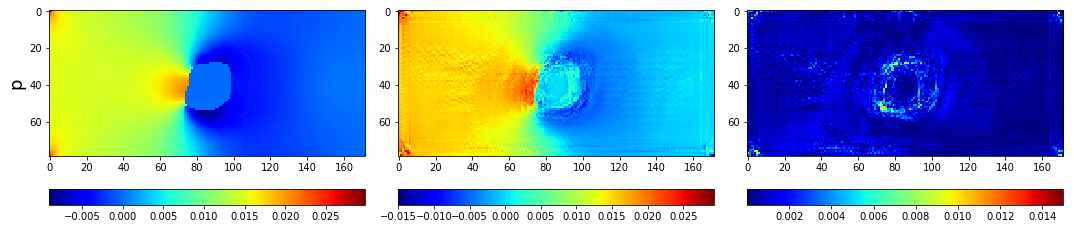

Epoch #21
	Train Loss = 1128812.982421875
	Train Total MSE = 0.9956915645549694
	Train p MSE = 0.9956915645549694
	Validation Loss = 501102.94677734375
	Validation Total MSE = 1.0961370878694998
	Validation p MSE = 1.0961370878694998
Model saved!
Epoch #22
	Train Loss = 1169773.51953125
	Train Total MSE = 1.0058400841163737
	Train p MSE = 1.0058400841163737
	Validation Loss = 552309.62109375
	Validation Total MSE = 1.1022154631989018
	Validation p MSE = 1.1022154631989018
Epoch #23
	Train Loss = 1180270.3359375
	Train Total MSE = 1.0022126782153333
	Train p MSE = 1.0022126782153333
	Validation Loss = 530073.7920532227
	Validation Total MSE = 1.11725525008869
	Validation p MSE = 1.11725525008869
Epoch #24
	Train Loss = 1131781.875
	Train Total MSE = 0.9962012549596173
	Train p MSE = 0.9962012549596173
	Validation Loss = 502500.84704589844
	Validation Total MSE = 1.0954342389215028
	Validation p MSE = 1.0954342389215028
Epoch #25
	Train Loss = 1089925.08984375
	Train Total MSE = 0.993010

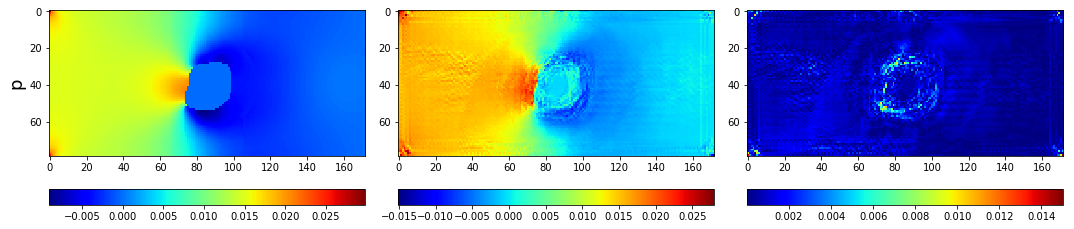

Epoch #31
	Train Loss = 1085947.3515625
	Train Total MSE = 0.9926853045998585
	Train p MSE = 0.9926853045998585
	Validation Loss = 492828.7097167969
	Validation Total MSE = 1.0866389032646653
	Validation p MSE = 1.0866389032646653
Epoch #32
	Train Loss = 1085620.54296875
	Train Total MSE = 0.9946680657920384
	Train p MSE = 0.9946680657920384
	Validation Loss = 483213.47186279297
	Validation Total MSE = 1.1000329140689753
	Validation p MSE = 1.1000329140689753
Epoch #33
	Train Loss = 1059508.8125
	Train Total MSE = 0.9965879304245824
	Train p MSE = 0.9965879304245824
	Validation Loss = 482310.0166015625
	Validation Total MSE = 1.1016613717181254
	Validation p MSE = 1.1016613717181254
Epoch #34
	Train Loss = 1051969.66796875
	Train Total MSE = 0.987515869239966
	Train p MSE = 0.987515869239966
	Validation Loss = 480343.24627685547
	Validation Total MSE = 1.0845346345234288
	Validation p MSE = 1.0845346345234288
Model saved!
Epoch #35
	Train Loss = 1055482.01171875
	Train Total MSE = 0.98

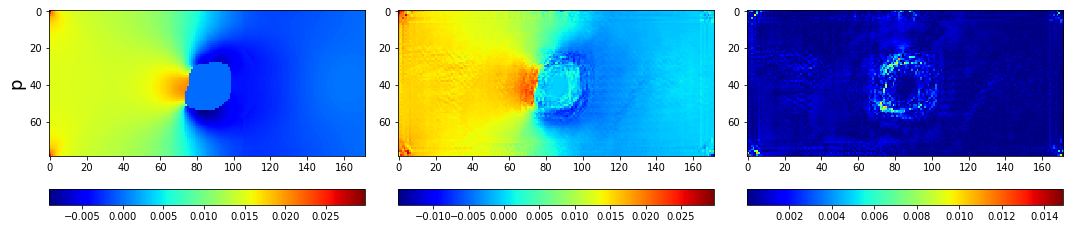

Epoch #41
	Train Loss = 1018734.603515625
	Train Total MSE = 0.9860838824617011
	Train p MSE = 0.9860838824617011
	Validation Loss = 475667.5552368164
	Validation Total MSE = 1.086803819030317
	Validation p MSE = 1.086803819030317
Epoch #42
	Train Loss = 1026848.63671875
	Train Total MSE = 0.9908249170652458
	Train p MSE = 0.9908249170652458
	Validation Loss = 464493.26232910156
	Validation Total MSE = 1.0849227486983921
	Validation p MSE = 1.0849227486983921
Epoch #43
	Train Loss = 1090569.240234375
	Train Total MSE = 0.9841875468513795
	Train p MSE = 0.9841875468513795
	Validation Loss = 534607.6799316406
	Validation Total MSE = 1.0823758945552227
	Validation p MSE = 1.0823758945552227
Epoch #44
	Train Loss = 1057812.302734375
	Train Total MSE = 0.9940257436108022
	Train p MSE = 0.9940257436108022
	Validation Loss = 462481.85174560547
	Validation Total MSE = 1.0789221231616182
	Validation p MSE = 1.0789221231616182
Epoch #45
	Train Loss = 997025.8671875
	Train Total MSE = 0.984397808

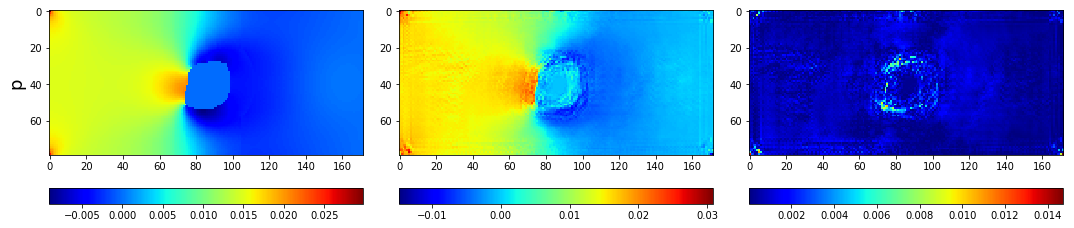

Epoch #51
	Train Loss = 968714.125
	Train Total MSE = 0.9809236828947351
	Train p MSE = 0.9809236828947351
	Validation Loss = 434498.1746826172
	Validation Total MSE = 1.0847061210824338
	Validation p MSE = 1.0847061210824338
Model saved!
Epoch #52
	Train Loss = 981503.076171875
	Train Total MSE = 0.9899438524707442
	Train p MSE = 0.9899438524707442
	Validation Loss = 444281.66583251953
	Validation Total MSE = 1.079275952710103
	Validation p MSE = 1.079275952710103
Epoch #53
	Train Loss = 997497.62109375
	Train Total MSE = 0.9909937271759623
	Train p MSE = 0.9909937271759623
	Validation Loss = 439702.01989746094
	Validation Total MSE = 1.0829728457586885
	Validation p MSE = 1.0829728457586885
Epoch #54
	Train Loss = 958256.744140625
	Train Total MSE = 0.9849995451846293
	Train p MSE = 0.9849995451846293
	Validation Loss = 442545.2604980469
	Validation Total MSE = 1.0784149784788128
	Validation p MSE = 1.0784149784788128
Epoch #55
	Train Loss = 995843.205078125
	Train Total MSE = 0.9828

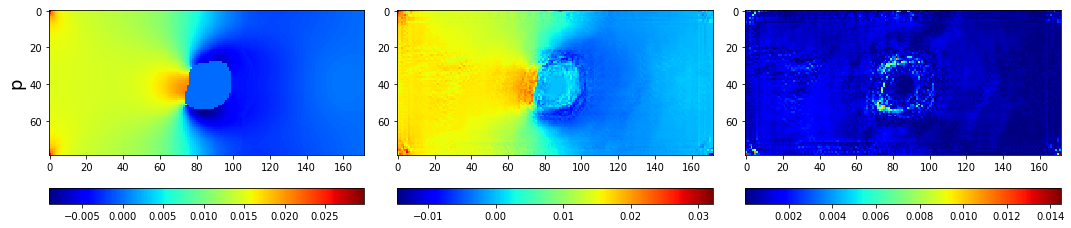

Epoch #61
	Train Loss = 954177.25390625
	Train Total MSE = 0.9868215302094108
	Train p MSE = 0.9868215302094108
	Validation Loss = 423860.2561035156
	Validation Total MSE = 1.0749551248269407
	Validation p MSE = 1.0749551248269407
Model saved!
Epoch #62
	Train Loss = 961153.02734375
	Train Total MSE = 0.9786995653772638
	Train p MSE = 0.9786995653772638
	Validation Loss = 446026.0124511719
	Validation Total MSE = 1.0811099304292338
	Validation p MSE = 1.0811099304292338
Epoch #63
	Train Loss = 957664.837890625
	Train Total MSE = 0.9824910300473372
	Train p MSE = 0.9824910300473372
	Validation Loss = 454941.51177978516
	Validation Total MSE = 1.0712857722307985
	Validation p MSE = 1.0712857722307985
Epoch #64
	Train Loss = 931065.470703125
	Train Total MSE = 0.9819158077062595
	Train p MSE = 0.9819158077062595
	Validation Loss = 411710.6875
	Validation Total MSE = 1.0818203218203928
	Validation p MSE = 1.0818203218203928
Model saved!
Epoch #65
	Train Loss = 906609.271484375
	Train Total

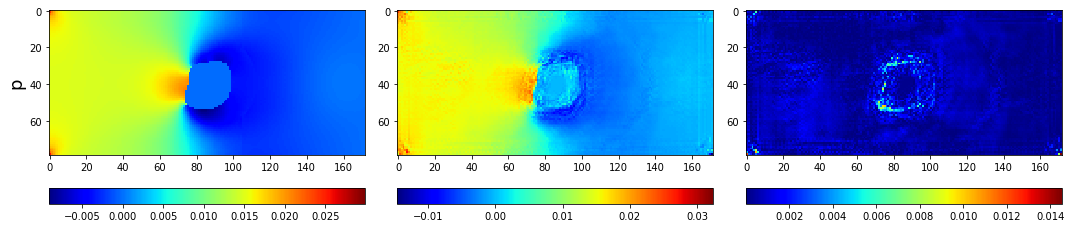

Epoch #71
	Train Loss = 958316.087890625
	Train Total MSE = 0.9832785506511018
	Train p MSE = 0.9832785506511018
	Validation Loss = 457108.962890625
	Validation Total MSE = 1.0669603933286966
	Validation p MSE = 1.0669603933286966
Epoch #72
	Train Loss = 902782.814453125
	Train Total MSE = 0.9755259345152548
	Train p MSE = 0.9755259345152548
	Validation Loss = 403936.744140625
	Validation Total MSE = 1.078116854865452
	Validation p MSE = 1.078116854865452
Model saved!
Epoch #73
	Train Loss = 870842.095703125
	Train Total MSE = 0.9777378322822707
	Train p MSE = 0.9777378322822707
	Validation Loss = 400575.82861328125
	Validation Total MSE = 1.0706912057867408
	Validation p MSE = 1.0706912057867408
Model saved!
Epoch #74
	Train Loss = 869418.85546875
	Train Total MSE = 0.9840412685381514
	Train p MSE = 0.9840412685381514
	Validation Loss = 399397.93365478516
	Validation Total MSE = 1.0700900463007106
	Validation p MSE = 1.0700900463007106
Model saved!
Epoch #75
	Train Loss = 904593.1875


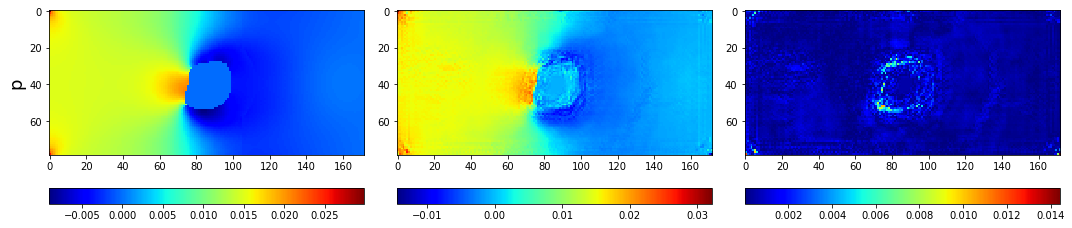

Epoch #81
	Train Loss = 958889.255859375
	Train Total MSE = 0.985534725089868
	Train p MSE = 0.985534725089868
	Validation Loss = 420723.33349609375
	Validation Total MSE = 1.0744045550022983
	Validation p MSE = 1.0744045550022983
Epoch #82
	Train Loss = 916174.447265625
	Train Total MSE = 0.9763760815951086
	Train p MSE = 0.9763760815951086
	Validation Loss = 406861.0617980957
	Validation Total MSE = 1.0664304276464256
	Validation p MSE = 1.0664304276464256
Epoch #83
	Train Loss = 876057.912109375
	Train Total MSE = 0.9735940467743647
	Train p MSE = 0.9735940467743647
	Validation Loss = 408489.93072509766
	Validation Total MSE = 1.085017518046921
	Validation p MSE = 1.085017518046921
Epoch #84
	Train Loss = 848030.435546875
	Train Total MSE = 0.9741414457204796
	Train p MSE = 0.9741414457204796
	Validation Loss = 417390.9597167969
	Validation Total MSE = 1.087576516236865
	Validation p MSE = 1.087576516236865
Epoch #85
	Train Loss = 843209.435546875
	Train Total MSE = 0.96831336981129

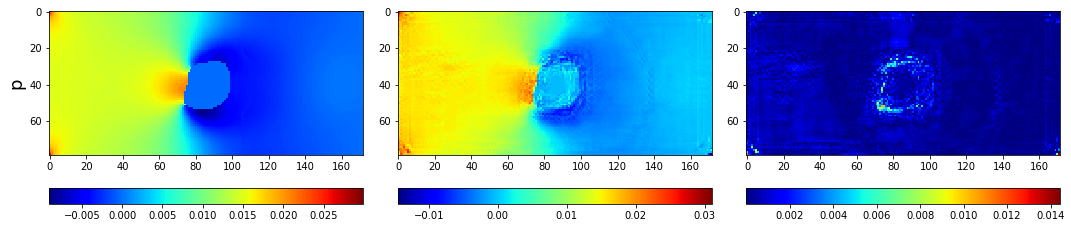

Epoch #91
	Train Loss = 876336.263671875
	Train Total MSE = 0.974860007386832
	Train p MSE = 0.974860007386832
	Validation Loss = 378621.7567138672
	Validation Total MSE = 1.0684456148581212
	Validation p MSE = 1.0684456148581212
Epoch #92
	Train Loss = 816069.275390625
	Train Total MSE = 0.9715580278564067
	Train p MSE = 0.9715580278564067
	Validation Loss = 384207.3737792969
	Validation Total MSE = 1.076105632596878
	Validation p MSE = 1.076105632596878
Epoch #93
	Train Loss = 812831.826171875
	Train Total MSE = 0.9761997407213563
	Train p MSE = 0.9761997407213563
	Validation Loss = 383248.5307006836
	Validation Total MSE = 1.0652127345044256
	Validation p MSE = 1.0652127345044256
Epoch #94
	Train Loss = 829051.74609375
	Train Total MSE = 0.9762585485087973
	Train p MSE = 0.9762585485087973
	Validation Loss = 368299.6022949219
	Validation Total MSE = 1.0675475507536356
	Validation p MSE = 1.0675475507536356
Model saved!
Epoch #95
	Train Loss = 824892.30078125
	Train Total MSE = 0.977

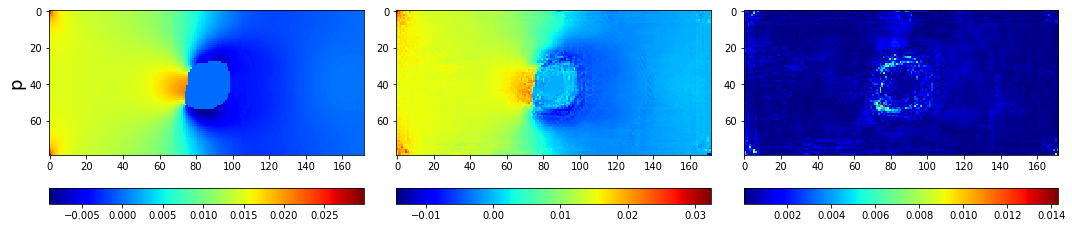

Epoch #101
	Train Loss = 800124.310546875
	Train Total MSE = 0.9761647266734924
	Train p MSE = 0.9761647266734924
	Validation Loss = 372929.48321533203
	Validation Total MSE = 1.0738221494783888
	Validation p MSE = 1.0738221494783888
Epoch #102
	Train Loss = 810048.0234375
	Train Total MSE = 0.9706567329842419
	Train p MSE = 0.9706567329842419
	Validation Loss = 388845.28607177734
	Validation Total MSE = 1.080984340832411
	Validation p MSE = 1.080984340832411
Epoch #103
	Train Loss = 820524.73046875
	Train Total MSE = 0.9799717089516067
	Train p MSE = 0.9799717089516067
	Validation Loss = 400280.89764404297
	Validation Total MSE = 1.0836509546413244
	Validation p MSE = 1.0836509546413244
Epoch #104
	Train Loss = 839092.291015625
	Train Total MSE = 0.9748042301230487
	Train p MSE = 0.9748042301230487
	Validation Loss = 371599.7989501953
	Validation Total MSE = 1.0754277682621483
	Validation p MSE = 1.0754277682621483
Epoch #105
	Train Loss = 795509.40625
	Train Total MSE = 0.97470965799

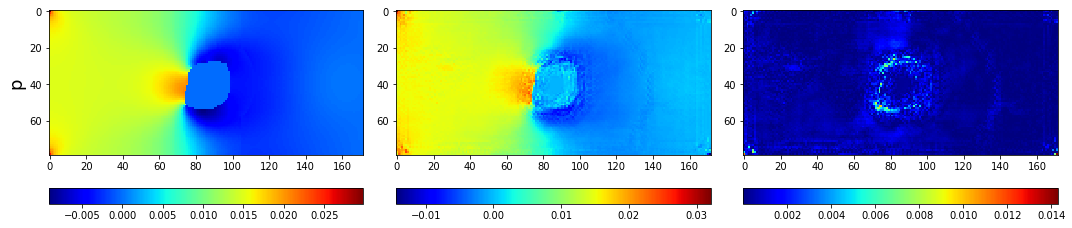

Epoch #111
	Train Loss = 792115.482421875
	Train Total MSE = 0.9764434456204375
	Train p MSE = 0.9764434456204375
	Validation Loss = 359850.74224853516
	Validation Total MSE = 1.064604705508966
	Validation p MSE = 1.064604705508966
Epoch #112
	Train Loss = 785465.728515625
	Train Total MSE = 0.9713757139674964
	Train p MSE = 0.9713757139674964
	Validation Loss = 365384.9928588867
	Validation Total MSE = 1.072079487789461
	Validation p MSE = 1.072079487789461
Epoch #113
	Train Loss = 811118.171875
	Train Total MSE = 0.9746230415822494
	Train p MSE = 0.9746230415822494
	Validation Loss = 370647.9921875
	Validation Total MSE = 1.0595088289457673
	Validation p MSE = 1.0595088289457673
Epoch #114
	Train Loss = 843858.494140625
	Train Total MSE = 0.9682540281099223
	Train p MSE = 0.9682540281099223
	Validation Loss = 407925.6131591797
	Validation Total MSE = 1.0855340426175446
	Validation p MSE = 1.0855340426175446
Epoch #115
	Train Loss = 818270.388671875
	Train Total MSE = 0.97346626900668

(UNet(
   (encoder): Sequential(
     (0): Sequential(
       (0): Sequential(
         (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
         (1): ReLU()
       )
       (1): Sequential(
         (0): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
         (1): ReLU()
       )
     )
     (1): Sequential(
       (0): Sequential(
         (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
         (1): ReLU()
       )
       (1): Sequential(
         (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
         (1): ReLU()
       )
     )
     (2): Sequential(
       (0): Sequential(
         (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
         (1): ReLU()
       )
       (1): Sequential(
         (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
         (1): ReLU()
       )
     )
     (3): Sequential(
       (0): Sequential(
         (0): Conv2d(32, 32, kernel

In [24]:
# Training model
train_model(model, loss_func, train_dataset, test_dataset, optimizer,
           epochs=10000, batch_size=32, device=device, after_epoch=after_epoch,
           m_mse_name="Total MSE",
           m_mse_on_batch=lambda scope: float(torch.sum((scope["output"] - scope["batch"][1]) ** 2)),
           m_mse_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_p_name="p MSE",
           m_p_on_batch=lambda scope: float(torch.sum((scope["output"][:,0,:,:] - scope["batch"][1][:,0,:,:]) ** 2)),
           m_p_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           )